# This makes sense to use using KMEANS or some other external-based-confidence score, but I didn't realize till I figured out the multiple inputs stuff, gonna leave it but actually work on the confidence-relabeling first

In [61]:
import os
from PIL import Image
import numpy as np
import random
import shutil

In [62]:
# define directories for train and validation sets
root_dir = '/projectnb/ds340/projects/Samuolis_Parikh_Image_Data/'

train_dir = root_dir +"resized_images/train"
validation_dir = root_dir + "resized_images/validation"

train_target = train_dir +"/baldeagle"
train_nontarget = train_dir +"/nonbaldeagle"

val_target = validation_dir +"/baldeagle"
val_nontarget = validation_dir +"/nonbaldeagle"

In [63]:
def load_images_from_folders(folder1, folder2, img_size = (224,224)):
    images = []
    labels = []
    
    # Load images from the first folder
    for filename in os.listdir(folder1):
        img_path = os.path.join(folder1, filename)
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                img = img.resize(img_size)
                images.append(np.array(img))  # Convert image to array
                labels.append(1)  # Class label for folder1
        except Exception as e:
            print(f"Could not load image {filename} from {folder1}: {e}")

    # Load images from the second folder
    for filename in os.listdir(folder2):
        img_path = os.path.join(folder2, filename)
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                img = img.resize(img_size)
                images.append(np.array(img))
                labels.append(0)  # Class label for folder2
        except Exception as e:
            print(f"Could not load image {filename} from {folder2}: {e}")

    # convert lists to NumPy arrays
    
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

images_train, label_train = load_images_from_folders(train_target, train_nontarget)
images_val, label_val = load_images_from_folders(val_target, val_nontarget)

In [64]:
## for debugging:
print(images_train.shape, label_train.shape, type(images_train))
print(images_train.min(), images_train.max())  # expected: 0 255, later will normalize
print(f"Initial eagle count: {np.sum(label_train == 1)}")
print(f"Initial noneagle count: {np.sum(label_train == 0)}")

(5200, 224, 224, 3) (5200,) <class 'numpy.ndarray'>
0 255
Initial eagle count: 1300
Initial noneagle count: 3900


In [65]:
def change_labels(labels, percentage):
    random.seed(340)
    label_one_indices = np.where(labels == 1)[0]
    
    n = int(len(label_one_indices) * (percentage / 100))
    
    indices_to_change = np.random.choice(label_one_indices, size=n, replace=False)
    
    labels[indices_to_change] = 0
    
    return labels, indices_to_change

# for example, change 20% of label 1s to label 0
percentage = 0  
# changed_indices
# label_train, changed_indices = change_labels(label_train, percentage)

In [66]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.keras.utils.set_random_seed(340)
tf.config.experimental.enable_op_determinism()

In [67]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]
epochs = 15
# restore best weights make the model be the one that was the best instead of last one
# patience changed from 4-->3

In [68]:
# reload images
images_train, label_train = load_images_from_folders(train_target, train_nontarget)
percentage = 20  
# changed_indices
label_train, changed_indices = change_labels(label_train, percentage)

In [69]:
print(f"New eagle count: {np.sum(label_train == 1)}")
print(f"New noneagle count: {np.sum(label_train == 0)}")

New eagle count: 1040
New noneagle count: 4160


In [70]:
from tensorflow.keras.layers import Input, Dropout, Concatenate
confidence_init = np.ones_like(label_train, dtype=float)  # Start with all 1s for confidence
confidence_init[label_train == 0] = 0  # Set confidence to 0 for original 0 labels
confidence_init[changed_indices] = 0.35  # Set confidence to 0.35 for flipped labels
confidence_init = confidence_init.reshape(-1, 1)  # Reshape to (N, 1)

# print data statistics
print(f"New eagle count: {np.sum(label_train == 1)}")
print(f"New noneagle count: {np.sum(label_train == 0)}")
print(f"Confidence values: {confidence_init[:10].flatten()}")

New eagle count: 1040
New noneagle count: 4160
Confidence values: [0.35 1.   1.   1.   1.   1.   1.   0.35 1.   1.  ]


In [71]:
# remake models
# mutliple inputs taken from chat and https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
# we have full confidence if it is a 1, the lower the number the more confident you are in the 0 class
# .999999 vs .00004

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True


# add new fully connected layers for binary classification
image_input = base_model.input
x = base_model.output
x = Flatten()(x)

additional_input = Input(shape=(1,), name="additional_input") # shape is just 1 feature for the confidence 
y = Dense(64, activation='relu')(additional_input) 
y = Dropout(0.1)(y) # when .5, the additional input was too powerful, the prediction vals were always either to close to 1 or 0, we try to make the additional input less important than the images

combined = Concatenate()([x, y]) # 2 channels
combined = Dense(256, activation='relu')(combined)
combined = Dense(1, activation='sigmoid')(combined)  # sigmoid for binary 

model = Model(inputs=[image_input, additional_input], outputs=combined)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], jit_compile=False)

### didnt run any of this


In [ ]:
history = model.fit(
    [images_train, confidence_init],
    label_train,
    batch_size = 32,
    epochs=epochs,  # adjust this for more epochs as needed
    validation_data=([images_val, label_val.reshape(-1,1)], label_val),
    callbacks = callbacks
)

In [ ]:
#accracy isnt what we care about rn, we care more about the confidence score and actual classigications
preds = model.predict([images_train, confidence_init])

In [14]:
changed_indices.sort()
changed_indices

array([   0,    7,   10,   15,   18,   25,   33,   34,   36,   43,   45,
         46,   47,   51,   53,   55,   59,   71,   72,   73,   74,   82,
         91,   93,   95,  105,  106,  107,  120,  123,  124,  130,  134,
        138,  145,  146,  148,  149,  150,  158,  160,  169,  193,  201,
        204,  207,  224,  228,  235,  239,  245,  249,  255,  260,  266,
        269,  273,  283,  290,  292,  293,  298,  304,  306,  307,  311,
        313,  315,  322,  326,  329,  336,  340,  341,  349,  351,  352,
        353,  357,  362,  364,  368,  370,  377,  378,  385,  386,  387,
        388,  392,  400,  403,  409,  410,  414,  417,  423,  428,  432,
        436,  438,  455,  458,  460,  465,  470,  477,  480,  482,  486,
        499,  511,  530,  533,  534,  537,  546,  547,  553,  564,  566,
        572,  573,  574,  578,  598,  601,  604,  619,  623,  634,  656,
        665,  666,  672,  674,  675,  677,  684,  687,  688,  689,  698,
        710,  720,  723,  724,  731,  734,  738,  7

In [15]:
np.where(label_train > .5)[0].shape #260 eagles missing, instead more eagles are getting flipped to noneagles

(1040,)

In [16]:
preds
preds.reshape(5200,)
np.where(preds.reshape(5200,) >.5)[0].shape #find indices of those 17 indexes that were incorrectly flipped and flip them to correct label

(1040,)

In [17]:
preds[changed_indices].mean() #preds for eagles labeled as 0, could we try flipping back top/highest value n percent of these back into eagles?

0.007381159

In [18]:
preds[1300:].mean() #noneagles labeled as noneagles

0.002475439

In [19]:
from scipy.stats import ttest_ind

tstat, pval = ttest_ind(preds[changed_indices], preds[1300:])

In [20]:
pval

array([2.51675191e-17])

In [23]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


and this

### riya 12/2 1

In [110]:
#trash rn
import numpy as np

# Define function to update labels based on misclassifications and confidence
def update_labels(preds, labels, changed_indices, confidence_init, threshold=0.05):
    new_labels = labels.copy()

    # Misclassified eagles: predicted as non-eagles (preds <= 0.5) but they are actually eagles (labels == 1)
    misclassified_eagles = np.where((labels[:1300] == 1) & (preds[:1300] <= 0.5))[0]

    # Adjust confidence for misclassifications within the eagle class
    for idx in misclassified_eagles:
        confidence_init[idx] = min(confidence_init[idx] + 0.1, 1)  # Increase confidence for eagle class

    # Flip misclassified eagles to eagles (preds closer to 1) if confidently predicted
    for idx in misclassified_eagles:
        new_labels[idx] = 1  # Flip to eagle

    return new_labels  

# Iterative relabeling process
converged = False
iteration = 0
threshold = 0.05  # Statistical significance level
tolerance = 0.01  # Convergence tolerance (less than 1% labels change)


# Start iterative process
while not converged:
    iteration += 1
    print(f"Iteration {iteration}...")

    # Retrain the model with the current labels and confidence scores
    history = model.fit(
        [images_train, confidence_init],  # Use updated confidence
        label_train,
        batch_size=32,
        epochs=1,  # To see values after each iteration
        validation_data=([images_val, label_val.reshape(-1, 1)], label_val),
        callbacks=callbacks,
        verbose=0
    )

    # Predict updated confidence scores from the model
    preds = model.predict([images_train, confidence_init]).flatten()

    # Filter `changed_indices` to keep only ambiguous predictions
    changed_indices = changed_indices[np.where((preds[changed_indices] > 0.3) & (preds[changed_indices] < 0.7))[0]]
    changed_indices = np.sort(changed_indices)

    print(f"Changed Indices: {changed_indices}")
    print(f"Predictions for Changed Indices: {preds[changed_indices]}")

    # Update labels based on misclassifications and confidence
    new_labels = update_labels(preds, label_train, changed_indices, confidence_init, threshold)

    # Update confidence scores to reflect updated predictions
    confidence_init = preds.reshape(-1, 1)

    # Check for convergence
    label_changes = np.sum(label_train != new_labels)
    change_ratio = label_changes / len(label_train)
    print(f"Label change ratio: {change_ratio:.4f}")
    print(f"Eagles in predictions: {np.sum(preds > 0.5)}")
    print(f"Noneagles in predictions: {np.sum(preds <= 0.5)}")

    # Check if the labels have converged by comparing the old and new labels
    if change_ratio < tolerance:  
        converged = True
    else:
        label_train = new_labels.copy()  # Update labels for the next iteration

print("Labels have converged.")

# Final print
eagle_count = np.sum(label_train == 1)
noneagle_count = np.sum(label_train == 0)
print(f"After Convergence - Correctly labeled eagles: {eagle_count}")
print(f"After Convergence - Correctly labeled noneagles: {noneagle_count}")


Iteration 1...
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step
Changed Indices: [  15   25   55   73  201  235  283  315  353  368  378  410  417  428
  432  438  455  465  530  547  578  674  684  724  802  803  829  836
  837  849  856  861  918  973 1029 1052 1085 1086 1101 1177 1193 1211
 1213 1221 1299]
Predictions for Changed Indices: [0.33993948 0.301688   0.31609848 0.346323   0.31062728 0.3332955
 0.31176782 0.31758687 0.33170742 0.30259776 0.3220533  0.3301907
 0.3241291  0.34405994 0.31074417 0.30899304 0.31454054 0.30906466
 0.36607313 0.30413967 0.39055392 0.31689996 0.3912428  0.34620482
 0.30776814 0.32108304 0.30376634 0.3192135  0.30213514 0.30695465
 0.49647298 0.3226291  0.37533212 0.31266627 0.31192333 0.3216466
 0.36463854 0.31626424 0.35049868 0.32555488 0.37126392 0.30479458
 0.31322291 0.31673646 0.36950284]
Label change ratio: 0.0000
Eagles in predictions: 1040
Noneagles in predictions: 4160
Labels have converged.
After Convergence - Correctly labeled eagles: 1040
Af

### riya 12/2 2

In [36]:
n_percentage = 5  # % of least confident eagle predictions to adjust
max_iterations = 3 # has biggest numbers from above output  
convergence_tolerance = 0  # stop if change ratio is this
high_conf_threshold = 0.8  # threshold for confident eagle flips

for iteration in range(max_iterations):
    print(f"Iteration {iteration + 1}...")

    # step 1: train model
    history = model.fit(
        [images_train, confidence_init],
        label_train,
        batch_size=100, # ok this might seem crazy but im wondering if w batch=32 it wasn't encountering enough wrong labels 
        epochs=1,
        # validation_data=([images_val, np.ones((len(images_val), 1))], label_val), # this was a line from chat, replaced w ours instead below
        validation_data=([images_val, label_val.reshape(-1,1)], label_val),
        callbacks=callbacks,
        verbose=0
    )

    # step 2: predict probabilities
    preds = model.predict([images_train, confidence_init]).flatten()

    # step 3: identify least confident eagle predictions
    low_confidence_indices = np.where((label_train == 0) & (preds < 0.5) & (preds != 0))[0] # grabbing indices where label_train is 0 (noneagle), focusing in on the misclassified
    sorted_indices = low_confidence_indices[np.argsort(preds[low_confidence_indices])] # sorts the preds low to high
    to_adjust = sorted_indices[:int(len(sorted_indices) * (n_percentage / 100))] # only grabbing 5% rn of the bottom

    # step 4: update confidence for least confident predictions
    if len(to_adjust) > 0:
        confidence_init[to_adjust] = 0  # reduce confidence to 0 for the indices we picked by %
        avg_confidence = np.mean(preds[to_adjust])
        print(f"Adjusted {len(to_adjust)} indices, avg confidence: {avg_confidence:.4f}")
    else:
        print("No indices to adjust in this iteration.")
    print(f"Changed Indices: {changed_indices}")
    print(f"Predictions for Changed Indices: {preds[changed_indices]}")


    # step 5: check for convergence
    if len(to_adjust) > 0:
            change_ratio = len(to_adjust) / len(label_train)  
    else:
            change_ratio=0
    print(f"Change ratio: {change_ratio:.4f}")

    if change_ratio < convergence_tolerance:
        print("Convergence reached.")
        break

# step 6: final flipping of high-confidence predictions to eagles
high_confidence_indices = np.where((label_train == 0) & (preds > .5))[0]
for idx in high_confidence_indices:
    label_train[idx] = 1  # flip to eagle
    confidence_init[idx] = 1  # restore confidence to 1 for flipped labels

print(f"Final eagle count: {np.sum(label_train == 1)}")
print(f"Final noneagle count: {np.sum(label_train == 0)}")

Iteration 1...
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step
Adjusted 208 indices, avg confidence: 0.0011
Changed Indices: [ 634 1050  370   34  986  149  499  720 1032  260  432  601  867  130
 1052  564  688  619  781  675  918 1178 1223  782  731  856  362  969
  578  861   72   71  743  283  837  313  882  134  938  822   10  311
  953   25  148  438  666  850  546  874 1240  849  378  377  249 1014
  160 1151  923   59  460  138 1187  573   15  470  723  794  106 1140
 1041  905  511  201  204  777  803  574 1211 1082 1249 1087  245  107
  533  307  341  604 1291 1105  410  207  877  913   53 1299 1265   55
  537 1203  292  547   47  351  818  790  865 1078  255  458 1101  235
  105  326  973  684   91 1263 1085   95  290    7 1029  945  926 1232
  672  859 1244  534  879  388  123  120 1100  909    0  266  455 1179
  553  269  322  304  298  724  884 1217  387 1268  598   74  677  530
   45  572 1213 1086 1103 1109  738   82  839  385  400  349 1177  900
  357  810   93 1235 1216  66

In [72]:
for iteration in range(max_iterations):
    print(f"Iteration {iteration + 1}...")

    # Step 1: Train model
    history = model.fit(
        [images_train, confidence_init],
        label_train,
        batch_size=32,
        epochs=1,
        validation_data=([images_val, np.ones((len(images_val), 1))], label_val),
        callbacks=callbacks,
        verbose=0
    )

    # Step 2: Predict probabilities
    preds = model.predict([images_train, confidence_init]).flatten()

    # Step 3: Identify least confident predictions
    low_confidence_indices = np.where((label_train == 0) & (preds < 0.5) & (preds != 0))[0]
    sorted_indices = low_confidence_indices[np.argsort(preds[low_confidence_indices])]
    to_adjust = sorted_indices[:int(len(sorted_indices) * (n_percentage / 100))]

    # Step 4: Update confidence for least confident predictions
    if len(to_adjust) > 0:
        confidence_init[to_adjust] *= 0.5  # Reduce confidence gradually
        avg_confidence = np.mean(preds[to_adjust])
        print(f"Adjusted {len(to_adjust)} indices, avg confidence: {avg_confidence:.4f}")
    else:
        print("No indices to adjust in this iteration.")

    # Step 5: Check for convergence
    change_ratio = len(to_adjust) / len(label_train) if len(to_adjust) > 0 else 0
    print(f"Change ratio: {change_ratio:.4f}")
    if change_ratio < convergence_tolerance:
        print("Convergence reached.")
        break

# Step 6: Final flipping of high-confidence predictions to eagles
preds = model.predict([images_train, confidence_init]).flatten()
high_confidence_indices = np.where((label_train == 0) & (preds > high_conf_threshold))[0]

if len(high_confidence_indices) > 0:
    label_train[high_confidence_indices] = 1
    confidence_init[high_confidence_indices] = 1
    print(f"Flipped {len(high_confidence_indices)} labels to eagle.")

# Retrain on fully updated dataset
print("Retraining model with updated labels...")
model.fit(
    [images_train, confidence_init],
    preds,
    batch_size=32,
    epochs=3,  # Add more epochs for final retraining
    validation_data=([images_val, np.ones((len(images_val), 1))], label_val),
    verbose=1
)

# Final counts
print(f"Final eagle count: {np.sum(label_train == 1)}")
print(f"Final noneagle count: {np.sum(label_train == 0)}")


Iteration 1...
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step
Adjusted 208 indices, avg confidence: 0.0170
Change ratio: 0.0400
Iteration 2...
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step
Adjusted 208 indices, avg confidence: 0.0012
Change ratio: 0.0400
Iteration 3...
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step
Adjusted 208 indices, avg confidence: 0.0001
Change ratio: 0.0400
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step
Retraining model with updated labels...
Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 140ms/step - accuracy: 0.0000e+00 - loss: 0.0130 - val_accuracy: 0.2500 - val_loss: 4.2549
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - accuracy: 0.0000e+00 - loss: 0.0127 - val_accuracy: 0.2500 - val_loss: 4.1080
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - accuracy: 0.0000e+00 - loss: 0.0127 - val_accuracy: 0.2500 - val_loss: 4.2142
Final eagle count: 1040
Final noneagle count: 4160


### just to test distributions / debug

In [34]:
# Compare relabeled classes to original ground truth
original_labels = new_labels  
correct_eagles = np.sum((label_train == 1) & (original_labels == 1))  # True eagles as eagles
correct_noneagles = np.sum((label_train == 0) & (original_labels == 0))  # True noneagles as noneagles

print(f"Correctly labeled eagles: {correct_eagles}/{np.sum(original_labels == 1)}")
print(f"Correctly labeled noneagles: {correct_noneagles}/{np.sum(original_labels == 0)}")


Correctly labeled eagles: 1040/1040
Correctly labeled noneagles: 4160/4160


In [70]:
eagle_confidence = preds[label_train == 1]
noneagle_confidence = preds[label_train == 0]

print(f"Mean confidence for eagles: {eagle_confidence.mean():.4f}")
print(f"Mean confidence for noneagles: {noneagle_confidence.mean():.4f}")


Mean confidence for eagles: 0.0297
Mean confidence for noneagles: 0.0079


In [34]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(eagle_confidence, noneagle_confidence, equal_var=False)
print(f"T-statistic: {t_stat:.4f}, P-value: {p_val:.4e}")


T-statistic: 285.7584, P-value: 0.0000e+00


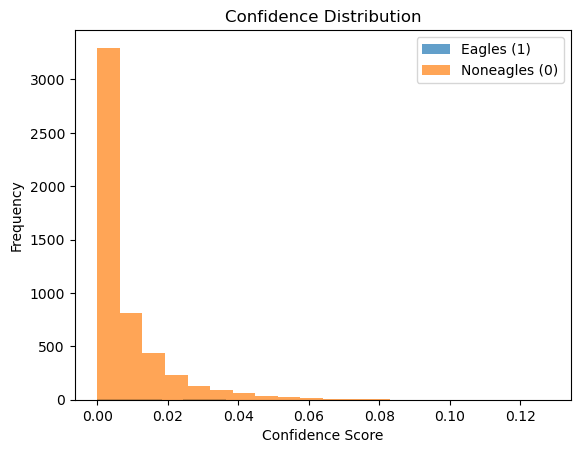

In [71]:
import matplotlib.pyplot as plt

plt.hist(eagle_confidence, bins=20, alpha=0.7, label='Eagles (1)')
plt.hist(noneagle_confidence, bins=20, alpha=0.7, label='Noneagles (0)')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Confidence Distribution')
plt.legend()
plt.show()


In [36]:
# Get indices of ambiguous samples
ambiguous_indices = np.where((preds > 0.4) & (preds < 0.6))[0]

# Inspect some ambiguous samples (requires image visualization logic)
for idx in ambiguous_indices[:10]:  # First 10 ambiguous cases
    print(f"Sample {idx}: Label={label_train[idx]}, Confidence={preds[idx]:.4f}")
    # Add your image visualization code here if needed


Sample 0: Label=0, Confidence=0.4747
Sample 1: Label=1, Confidence=0.5125
Sample 2: Label=1, Confidence=0.5125
Sample 3: Label=1, Confidence=0.5125
Sample 4: Label=1, Confidence=0.5125
Sample 5: Label=1, Confidence=0.5125
Sample 6: Label=1, Confidence=0.5125
Sample 7: Label=0, Confidence=0.4747
Sample 8: Label=1, Confidence=0.5125
Sample 9: Label=1, Confidence=0.5125
